"""
Road Data Preprocessing for Boroondara Region

This notebook performs multi-step preprocessing of road network shapefiles and infrastructure data
for the Boroondara area.  

Outputs:
- Prints and visualizations of boundary, roads, and intersections
- GeoDataFrame containing filtered major intersections
- Optional: save outputs to file for integration with traffic datasets

"""


# Load Geographic Boundary Data

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Define paths
road_data_dir = "../road_data"
vmtrans_dir = os.path.join(road_data_dir, "mga2020_55/esrishape/lga_polygon/BOROONDARA-0/VMTRANS")
boroondara_boundary_path = os.path.join(road_data_dir, "mga2020_55/esrishape/lga_polygon/BOROONDARA-0/EXTRACT_POLYGON.shp")

# Read Boroondara boundary
print("Reading Boroondara boundary...")
try:
    boroondara_boundary = gpd.read_file(boroondara_boundary_path)
    print(f"Boroondara boundary loaded: {len(boroondara_boundary)} polygons")
    print(f"CRS: {boroondara_boundary.crs}")
except Exception as e:
    print(f"Error reading boundary: {e}")
    boroondara_boundary = None

Reading Boroondara boundary...
Boroondara boundary loaded: 11 polygons
CRS: EPSG:7855


# Process Road Network Data

In [1]:
# Read and process road network
print("\nReading road network data...")
try:
    road_network = gpd.read_file(os.path.join(vmtrans_dir, "TR_ROAD.shp"))
    print(f"Road network loaded: {len(road_network)} road segments")
    print(f"Road network columns: {road_network.columns.tolist()}")
    
    # Read column names description if available
    column_desc_path = os.path.join(vmtrans_dir, "tr_road_column_names.txt")
    if os.path.exists(column_desc_path):
        with open(column_desc_path, 'r') as f:
            column_desc = f.read()
            print("\nRoad network column descriptions:")
            print(column_desc[:500] + "..." if len(column_desc) > 500 else column_desc)
except Exception as e:
    print(f"Error reading road network: {e}")
    road_network = None


Reading road network data...
Error reading road network: name 'gpd' is not defined


# Analyze Road Infrastructure

In [3]:
# Read road infrastructure data (may contain intersection information)
print("\nReading road infrastructure data...")
try:
    road_infra = gpd.read_file(os.path.join(vmtrans_dir, "TR_ROAD_INFRASTRUCTURE.shp"))
    print(f"Road infrastructure loaded: {len(road_infra)} features")
    print(f"Road infrastructure columns: {road_infra.columns.tolist()}")
    
    # Check if there are intersection-related features
    if road_infra is not None:
        # Look specifically for 'FTYPE_CODE' as it contains intersection info
        if 'FTYPE_CODE' in road_infra.columns:
            intersection_types = [val for val in road_infra['FTYPE_CODE'].unique() 
                                 if isinstance(val, str) and 'int_' in val.lower()]
            print(f"Intersection types in FTYPE_CODE: {intersection_types}")
            
            # Filter infrastructure points that are intersections
            intersections_infra = road_infra[road_infra['FTYPE_CODE'].isin(intersection_types)]
            print(f"Found {len(intersections_infra)} intersection features")
        else:
            print("FTYPE_CODE column not found")
            intersections_infra = None
except Exception as e:
    print(f"Error reading road infrastructure: {e}")
    road_infra = None
    intersections_infra = None


Reading road infrastructure data...
Road infrastructure loaded: 4898 features
Road infrastructure columns: ['UFI', 'PFI', 'FTYPE_CODE', 'NAME', 'NFEAT_ID', 'HT_LIMIT', 'PHYS_COND', 'CONST_TYPE', 'ROTATION', 'STRUC_TYPE', 'LOAD_LIMIT', 'LDLMTASSDT', 'CONS_MAT', 'LENGTH_M', 'WIDTH_M', 'DECK_AREA', 'RESPAUTHCD', 'COORDAUTHC', 'URBAN', 'CONPFI1', 'CONPFI2', 'FQID', 'TASK_ID', 'CRDATE_PFI', 'SUPER_PFI', 'CRDATE_UFI', 'geometry']
Intersection types in FTYPE_CODE: ['int_nosignal', 'int_attribute', 'int_signal', 'int_locality']
Found 4160 intersection features


# Visualize Road Network and Intersections
##  Identify Major Intersections


Creating visualization...
Plotted 3712 signal-controlled intersections
Visualization saved to ../road_data/boroondara_road_network.png
Identified 3847 major intersections based on network topology
Major intersections visualization saved to ../road_data/boroondara_major_intersections.png
Major intersections saved to ../road_data/boroondara_major_intersections.shp


/var/folders/yr/mm0xskxn61jfrkxwp3y0mc7w0000gn/T/ipykernel_2459/1762617685.py:73: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  major_intersections.to_file(os.path.join(road_data_dir, "boroondara_major_intersections.shp"))
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'intersection_id' to 'intersecti'
  ogr_write(


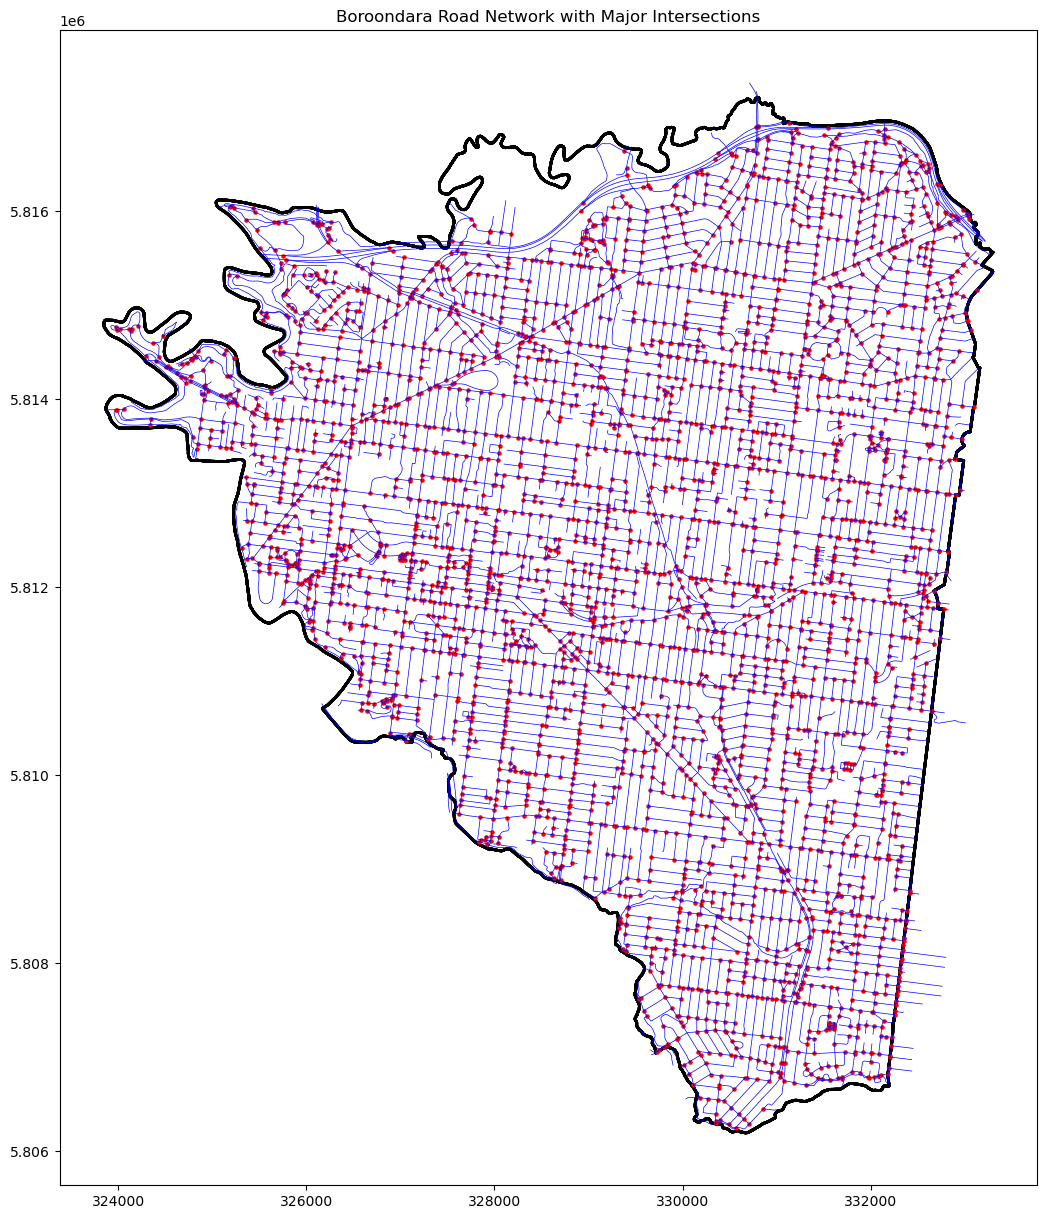

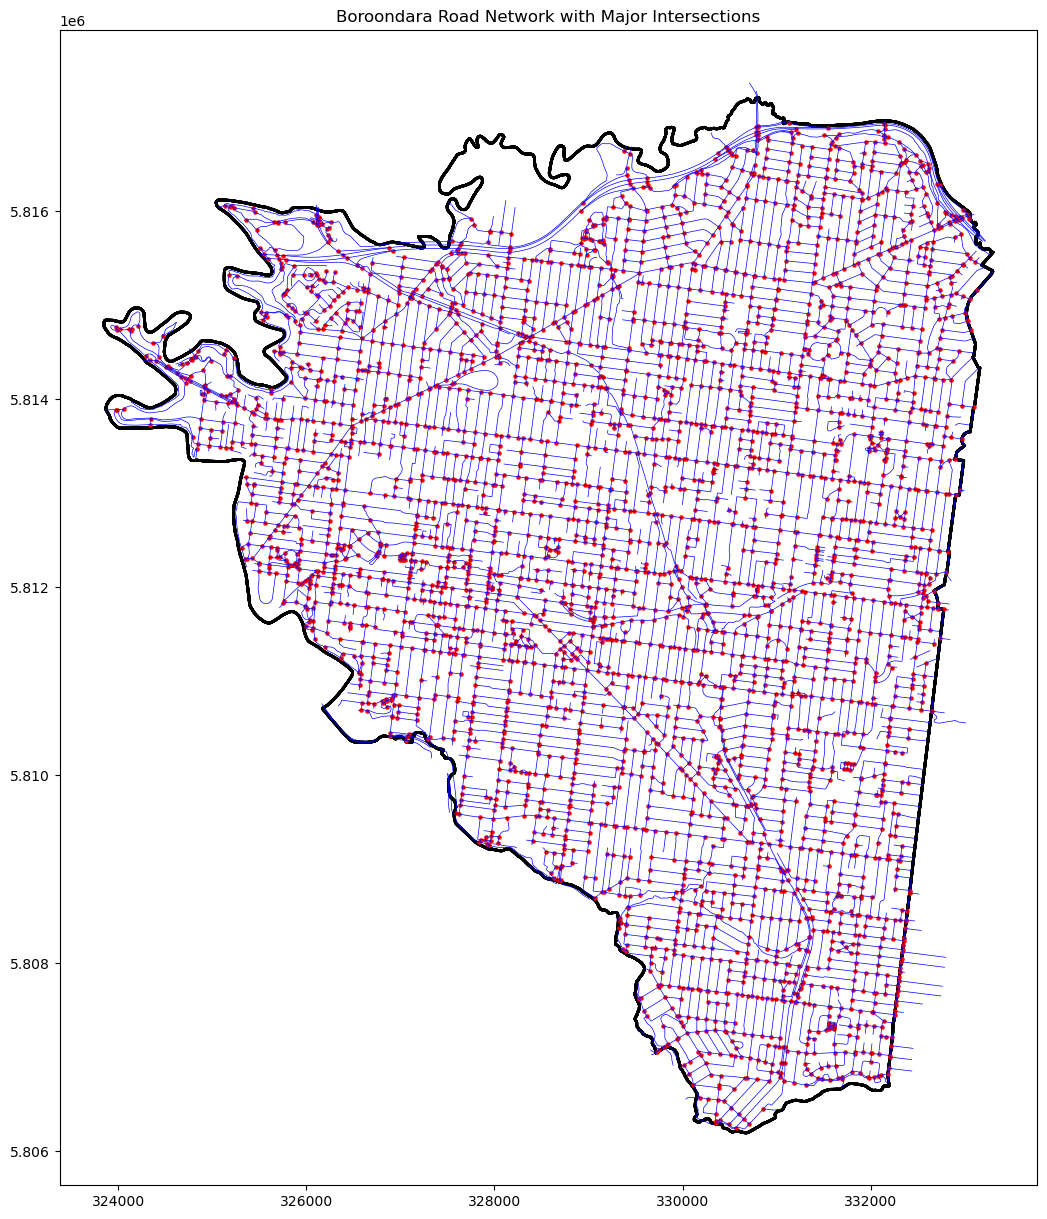

In [4]:
# Create visualization of the road network with filtered intersections
print("\nCreating visualization...")
try:
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot boundary if available
    if boroondara_boundary is not None:
        boroondara_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
    
    # Plot road network
    if road_network is not None:
        road_network.plot(ax=ax, color='blue', linewidth=0.5)
    
    # Plot filtered intersections
    if intersections_infra is not None and len(intersections_infra) > 0:
        # Filter to keep only signal-controlled intersections (likely to be SCATS sites)
        signal_intersections = intersections_infra[
            intersections_infra['FTYPE_CODE'].isin(['int_signal', 'int_nosignal'])
        ]
        
        if len(signal_intersections) > 0:
            signal_intersections.plot(ax=ax, color='red', markersize=5)
            print(f"Plotted {len(signal_intersections)} signal-controlled intersections")
        else:
            # If no signal intersections found, use all intersections but with smaller markers
            intersections_infra.plot(ax=ax, color='red', markersize=3)
            print(f"Plotted {len(intersections_infra)} total intersections")
    
    plt.title("Boroondara Road Network with Major Intersections")
    plt.savefig(os.path.join(road_data_dir, "boroondara_road_network.png"), dpi=300)
    print(f"Visualization saved to {os.path.join(road_data_dir, 'boroondara_road_network.png')}")
    
    # Identify major intersections by finding where multiple road segments meet
    if road_network is not None:
        from shapely.geometry import Point
        from collections import Counter
        
        # Extract endpoints of all lines
        endpoints = []
        for line in road_network.geometry:
            if line.geom_type == 'LineString':
                endpoints.append(Point(line.coords[0]))
                endpoints.append(Point(line.coords[-1]))
            elif line.geom_type == 'MultiLineString':
                for subline in line.geoms:
                    endpoints.append(Point(subline.coords[0]))
                    endpoints.append(Point(subline.coords[-1]))
        
        # Count occurrences of each point
        point_counts = Counter([(round(p.x, 1), round(p.y, 1)) for p in endpoints])
        
        # Find points that appear at least 3 times (major intersections)
        major_points = [Point(p) for p, count in point_counts.items() if count >= 3]
        
        # Create GeoDataFrame for major intersections
        major_intersections = gpd.GeoDataFrame(geometry=major_points, crs=road_network.crs)
        major_intersections['intersection_id'] = range(len(major_intersections))
        
        print(f"Identified {len(major_intersections)} major intersections based on network topology")
        
        # Create a visualization with only major intersections
        fig, ax = plt.subplots(figsize=(15, 15))
        if boroondara_boundary is not None:
            boroondara_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
        road_network.plot(ax=ax, color='blue', linewidth=0.5)
        major_intersections.plot(ax=ax, color='red', markersize=5)
        
        plt.title("Boroondara Road Network with Major Intersections")
        plt.savefig(os.path.join(road_data_dir, "boroondara_major_intersections.png"), dpi=300)
        print(f"Major intersections visualization saved to {os.path.join(road_data_dir, 'boroondara_major_intersections.png')}")
        
        # Save major intersections to shapefile
        major_intersections.to_file(os.path.join(road_data_dir, "boroondara_major_intersections.shp"))
        print(f"Major intersections saved to {os.path.join(road_data_dir, 'boroondara_major_intersections.shp')}")
except Exception as e:
    print(f"Error creating visualization or identifying major intersections: {e}")

# Create Enhanced Road Network Dataset
## Generate improved road network and intersection datasets
## Export final processed data in multiple formats for use in traffic analysis


Saving processed road network data with improvements...
Identified 3847 intersections from road network analysis
Filtered to 3847 major intersections
Major intersections saved to:
 - Shapefile: ../road_data/boroondara_major_intersections.shp
 - GeoJSON: ../road_data/boroondara_major_intersections.geojson
Simplified road network saved to:
 - Shapefile: ../road_data/boroondara_road_network_simple.shp
 - GeoJSON: ../road_data/boroondara_road_network.geojson
Top intersections visualization saved to: ../road_data/boroondara_top_intersections.png

Road data processing complete!


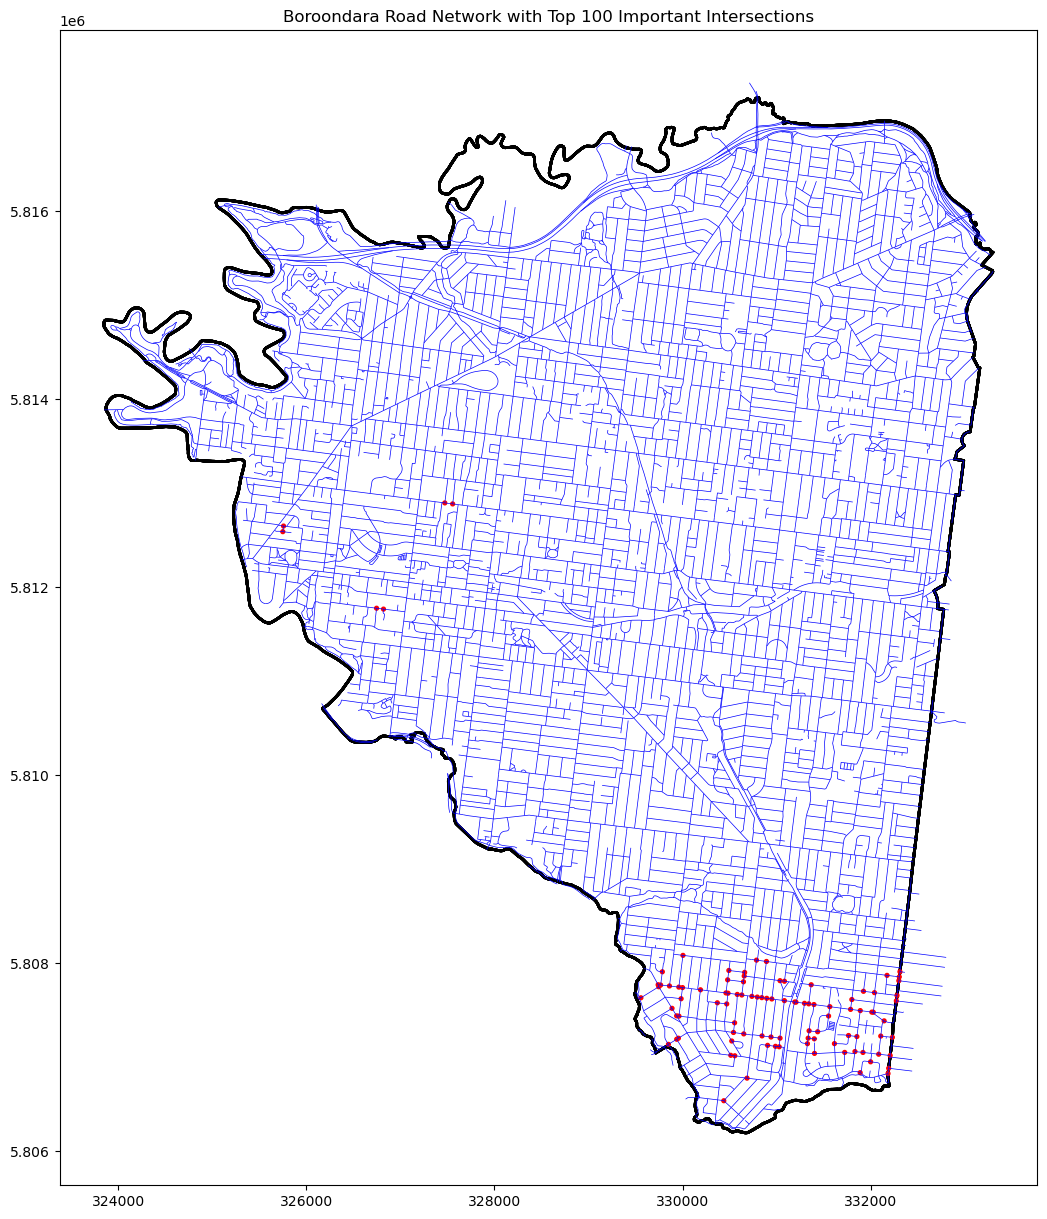

In [5]:
# Save processed road network data with improved filtering and attributes
print("\nSaving processed road network data with improvements...")
try:
    if road_network is not None:
        # Recreate intersections_gdf from scratch
        from shapely.geometry import Point
        from collections import Counter
        
        # Extract endpoints of all lines
        endpoints = []
        for line in road_network.geometry:
            if line.geom_type == 'LineString':
                endpoints.append(Point(line.coords[0]))
                endpoints.append(Point(line.coords[-1]))
            elif line.geom_type == 'MultiLineString':
                for subline in line.geoms:
                    endpoints.append(Point(subline.coords[0]))
                    endpoints.append(Point(subline.coords[-1]))
        
        # Count occurrences of each point
        point_counts = Counter([(round(p.x, 1), round(p.y, 1)) for p in endpoints])
        
        # Find points that appear at least 3 times (major intersections)
        major_points = [Point(p) for p, count in point_counts.items() if count >= 3]
        
        # Create GeoDataFrame for intersections
        import geopandas as gpd
        intersections_gdf = gpd.GeoDataFrame(geometry=major_points, crs=road_network.crs)
        intersections_gdf['intersection_id'] = range(len(intersections_gdf))
        
        print(f"Identified {len(intersections_gdf)} intersections from road network analysis")
        
        # Now continue with the rest of step 6
        # Add count information to intersections
        intersection_counts = []
        for point in intersections_gdf.geometry:
            count = point_counts.get((round(point.x, 1), round(point.y, 1)), 0)
            intersection_counts.append(count)
        
        intersections_gdf['road_count'] = intersection_counts
        
        # Filter to keep only major intersections (3 or more roads meeting)
        major_intersections = intersections_gdf[intersections_gdf['road_count'] >= 3].copy()
        
        # Rename intersection_id to avoid shapefile truncation
        major_intersections = major_intersections.rename(columns={'intersection_id': 'int_id'})
        
        # Add coordinates for easier joining with SCATS data later
        major_intersections['x_coord'] = major_intersections.geometry.x
        major_intersections['y_coord'] = major_intersections.geometry.y
        
        # Add importance rank based on road count
        major_intersections['importance'] = major_intersections['road_count'].rank(method='dense', ascending=False)
        
        print(f"Filtered to {len(major_intersections)} major intersections")
        
        # Try to add road names to intersections if possible
        buffered_intersections = major_intersections.copy()
        buffered_intersections.geometry = buffered_intersections.geometry.buffer(10)  # 10 meter buffer
        
        # Find road segments that intersect with each buffered intersection
        intersection_roads = []
        for idx, intersection in buffered_intersections.iterrows():
            nearby_roads = road_network[road_network.intersects(intersection.geometry)]
            road_names = []
            for _, road in nearby_roads.iterrows():
                if 'ROAD_NAME' in road and road['ROAD_NAME'] and str(road['ROAD_NAME']).strip():
                    road_names.append(str(road['ROAD_NAME']).strip())
            
            # Take up to 2 unique road names
            unique_roads = list(set(road_names))[:2]
            intersection_roads.append(' / '.join(unique_roads) if unique_roads else 'Unknown')
        
        major_intersections['roads'] = intersection_roads
        
        # Save to both Shapefile and GeoJSON
        shapefile_path = os.path.join(road_data_dir, "boroondara_major_intersections.shp")
        geojson_path = os.path.join(road_data_dir, "boroondara_major_intersections.geojson")
        
        major_intersections.to_file(shapefile_path)
        major_intersections.to_file(geojson_path, driver='GeoJSON')
        
        print(f"Major intersections saved to:")
        print(f" - Shapefile: {shapefile_path}")
        print(f" - GeoJSON: {geojson_path}")
        
        # Create a simplified version of the road network
        essential_cols = ['geometry']
        
        important_attrs = ['ROAD_NAME', 'HT_LIMIT', 'ROAD_TYPE', 'CLASS_CODE']
        for attr in important_attrs:
            if attr in road_network.columns:
                essential_cols.append(attr)
        
        simplified_network = road_network[essential_cols].copy()
        simplified_path = os.path.join(road_data_dir, "boroondara_road_network_simple.shp")
        simplified_network.to_file(simplified_path)
        
        geojson_network_path = os.path.join(road_data_dir, "boroondara_road_network.geojson")
        simplified_network.to_file(geojson_network_path, driver='GeoJSON')
        
        print(f"Simplified road network saved to:")
        print(f" - Shapefile: {simplified_path}")
        print(f" - GeoJSON: {geojson_network_path}")
        
        # Create visualization for top 100 intersections
        import matplotlib.pyplot as plt
        top_intersections = major_intersections.nlargest(100, 'importance')
        
        fig, ax = plt.subplots(figsize=(15, 15))
        
        if boroondara_boundary is not None:
            boroondara_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
        
        simplified_network.plot(ax=ax, color='blue', linewidth=0.5)
        top_intersections.plot(ax=ax, color='red', markersize=top_intersections['importance']/2 + 5)
        
        plt.title("Boroondara Road Network with Top 100 Important Intersections")
        top_intersections_path = os.path.join(road_data_dir, "boroondara_top_intersections.png")
        plt.savefig(top_intersections_path, dpi=300)
        
        print(f"Top intersections visualization saved to: {top_intersections_path}")
        
except Exception as e:
    print(f"Error in improved step 6: {e}")

print("\nRoad data processing complete!")